In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/tools/tokenization.py

--2023-07-01 15:05:55--  https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/tools/tokenization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16591 (16K) [text/plain]
Saving to: ‘tokenization.py’

tokenization.py     100%[===================>]  16.20K  --.-KB/s    in 0.002s  

2023-07-01 15:05:55 (10.4 MB/s) - ‘tokenization.py’ saved [16591/16591]



In [ ]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.0 MB/s eta 0:00:00


Các thư viện cần thiết

In [ ]:
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import tensorflow_hub as hub
from tokenization import FullTokenizer

Ta đọc file vào dataframe

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/dataNLP/clean_train.csv',index_col = 0)
df_train = df_train.fillna(' ')
df_train.head(5)

,keyword,location,text,target,cleaned_text
id,,,,,
1,,,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
4,,,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
5,,,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
6,,,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...
7,,,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/dataNLP/clean_test.csv',index_col = 0)
df_test = df_test.fillna(' ')
df_test.head(5)

,keyword,location,text,cleaned_text
id,,,,
0,,,Just happened a terrible car crash,happened terrible car crash
2,,,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...
3,,,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...
9,,,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
11,,,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan


Ta lưu các thuộc tính vào các biến để tiện xử lý

In [ ]:
x_train = df_train['cleaned_text'].values
y_train = df_train['target'].values

x_test = df_test['cleaned_text'].values

# 1. Naïve Bayes Classification (NBC)

Naïve  Bayes Classification (NBC) là một thuật toán phân loại dựa trên tính toán xác suất áp dụng định lý Bayes. Thuật toán này thuộc nhóm Supervised Learning (Học có giám sát).

### Tạo đặc trưng và chuẩn bị dữ liệu:
Sử dụng TF-IDF (Term Frequency - Inverse Document Frequency ) để tạo đặc trưng cho dữ liệu để áp dụng vào mô hình NBC. TF-IDF được sử dụng để đại diện cho các văn bản dựa trên tần suất xuất hiện của các từ trong văn bản và toàn bộ tập dữ liệu.

Sau khi sử dụng thì dữ liệu dạng text ban đầu sẽ chuyển đổi thành ma trận term frequency-inverse document frequency (TF-IDF matrix).

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)
x_train_vec = vectorizer.transform(x_train)

Chia tập dữ liệu thành 2 tập train và test

In [ ]:
X_train_NB, X_test_NB, y_train_NB, y_test_NB = train_test_split(x_train_vec, y_train,  test_size = 0.2)

### Huấn luyện và đánh giá dữ liệu trên tập train và test đã chuẩn bị
Dùng mô hình Naive Bayes Classification để phân lớp nhị phân dữ liệu với dữ liệu đầu vào ma trận TD-IDF đã được tạo ở trên. Sau đó dùng mô hình đã huấn luyện được để áp dụng cho dữ liệu test. Từ đó có những đánh giá tổng quan hơn

In [ ]:
clf = MultinomialNB().fit(X_train_NB,y_train_NB)
predicted = clf.predict(X_test_NB)

Hàm đánh giá mô hình gồm các độ đo là Accuracy, Precision, Recall và Confusion matrix

In [ ]:
def eval(y, y_pre):
  print('\n Accuracy:',metrics.accuracy_score(y, y_pre))
  print('\n Confusion matrix: ')
  print(metrics.confusion_matrix(y, y_pre))
  print('\n Precision:', metrics.precision_score(y, y_pre))
  print('\n Recall:', metrics.recall_score(y, y_pre))

Đánh giá trên dữ liệu đã dự đoán

In [ ]:
eval(y_test_NB, predicted)


 Accuracy: 0.8095863427445831

 Confusion matrix: 
[[779  85]
 [205 454]]

 Precision: 0.8423005565862709

 Recall: 0.6889226100151745


Mô hình của bạn có Accuracy tương đối cao và Precision cũng khá tốt. Tuy nhiên, Recall chưa cao. Mô hình còn chưa hoạt động tốt khi còn bỏ xót nhiều nhãn positive.

### Áp dụng mô hình cho tập test và xuất file nộp lên Kaggle

Đọc file submission mẫu. Sau đó tạo đặc trưng cho dữ liệu test và áp dụng mô hình đã huấn luyện vào.

In [ ]:
df_sub_NB = pd.read_csv('/content/drive/MyDrive/dataNLP/sample_submission.csv')

In [ ]:
X_sub = vectorizer.transform(x_test)
df_sub_NB['target'] = clf.predict(X_sub)

In [ ]:
df_sub_NB.to_csv("/content/drive/MyDrive/dataNLP/NB_submission.csv", index=False, header=True)

#### Nhận xét và hướng phát triển

- Sau khi nộp *NB_submission.csv* lên Kaggle thì được Score 0,798 không quá cao. Nhưng mô hình cũng đã cho thấy kết quả khá tốt trên tập test của Kaggle.
- Để cải thiện mô hình, ta cải thiện việc xử lý dữ liệu, mở rộng từ vựng,... Ngoài ra ta có thể tinh chỉnh các tham số của mô hình như confidence level hay các giả định khác để có thể tăng thêm độ chính xác cho mô hình.
- Ngoài ra, ta có thể sử dụng các mô hình phân loại khác để tìm ra mô hình phù hợp hơn.



# 2. BERT

BERT là viết tắt của "Bidirectional Encoder Representations from Transformers". Đây là một mô hình ngôn ngữ dựa trên kiến trúc Transformer và được giới thiệu bởi nhóm nghiên cứu của Google AI vào năm 2018.

BERT sử dụng kiến trúc Transformer để xử lý các chuỗi đầu vào và học cách biểu diễn các từ và câu trong ngữ cảnh của chúng. Điểm đặc biệt của BERT là nó sử dụng quá trình "bidirectional training", tức là mô hình được huấn luyện để hiểu cả ngữ cảnh trước và sau của một từ trong câu. Điều này giúp BERT hiểu được ngữ nghĩa của từ dựa trên ngữ cảnh xung quanh.

Vì đã có nhiều model BERT được xây dựng ở trên mạng nên nhóm em sẽ down về và thực hiện fine-tuning đối với bộ dữ liệu này

BERT hiện có 2 kiến trúc:
  - BERT Base: 12 layers (transformer blocks), 12 attention heads, và 110 triệu parameters (tụi em sẽ dùng cái này để tiết kiệm tài nguyên.
  - BERT Large: 24 layers (transformer blocks), 16 attention heads và, 340 triệu parameters

### Tạo đặc trưng cho mô hình

Mô hình BERT sẽ nhận vào 3 thành phần đầu vào là:
   - input_word_ids:  Đây là một chuỗi các số nguyên, biểu diễn mã hóa các từ trong câu hoặc cặp câu.
   - input_mask: giá trị 1 ở vị trí tương ứng trong input_mask cho biết từ tại vị trí đó là một từ thực sự, trong khi giá trị 0 thì là từ đệm.
   - segment_ids: được sử dụng để phân biệt các từ thuộc về câu đầu tiên và câu thứ hai, tuy nhiên vì ta chỉ input vào một câu nên ta không cần phân biệt (để giá trị 0).

Hàm bert_encode giúp ta chuyển đổi một câu text sang 3 thành phần này để input vào BERT

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
        text = tokenizer.tokenize(text)

        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)

        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

### Xây dựng mô hình

Ta sẽ thêm một lớp output có activation là sigmoid để phù hợp cho bài toán

In [ ]:
def build_model(bert_layer, max_len=512,Dropout_num = 0):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]

    if Dropout_num == 0:

        out = Dense(1, activation='sigmoid')(clf_output)
    else:

        x = Dropout(Dropout_num)(clf_output)
        out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    optimizer = Adam(learning_rate=1e-5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


Load model đã được train từ trước từ tfhub

In [ ]:
%%time

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=True)

CPU times: user 9.32 s, sys: 2.79 s, total: 12.1 s
Wall time: 30.1 s


In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

Ta mã hoá tập train qua hàm bert_encode để đưa vào model

In [ ]:
train_input = bert_encode(x_train, tokenizer, max_len=160)
train_labels = y_train

In [ ]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 160)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 160)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 160)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 160, 768)]                'input_mask[0][0]',         

Thông qua checkpoint, ta sẽ lưu mô hình có trọng số tốt nhất thông qua quá trình train, vì có thể quá trình train có hiện tượng overfit dẫn đến càng train thì giá trị val_loss càng tăng. Nên ta sẽ lưu trọng số của mô hình có giá trị val nhỏ nhất

In [ ]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint],
    batch_size=16
)

Epoch 1/3
381/381 [==============================] - 275s 578ms/step - loss: 0.4466 - accuracy: 0.8026 - val_loss: 0.4119 - val_accuracy: 0.8102
Epoch 2/3
381/381 [==============================] - 214s 563ms/step - loss: 0.2887 - accuracy: 0.8877 - val_loss: 0.4383 - val_accuracy: 0.8056
Epoch 3/3
381/381 [==============================] - 214s 562ms/step - loss: 0.1412 - accuracy: 0.9458 - val_loss: 0.4943 - val_accuracy: 0.8129


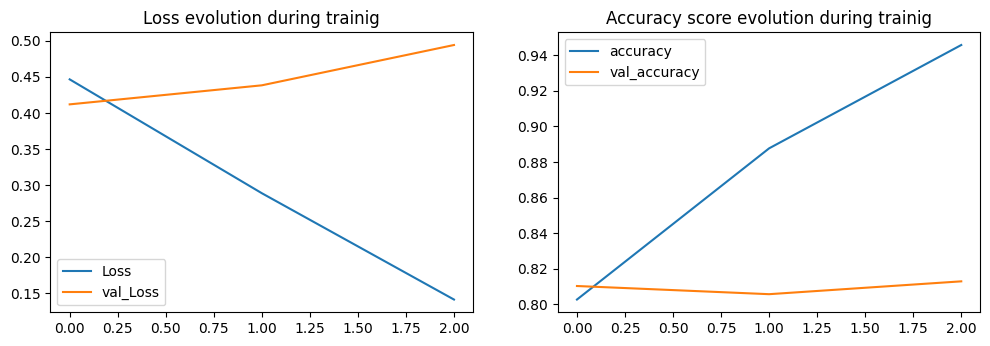

In [ ]:
def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['accuracy'], label='accuracy')
    plt.plot(r.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy score evolution during trainig')
    plt.legend()

plot_learning_evolution(train_history)

In [ ]:
y_pre = model.predict(train_input)
y_pre = y_pre.round().astype('int')

238/238 [==============================] - 93s 388ms/step


In [ ]:
eval(train_labels, y_pre)


 Accuracy: 0.9440430841980822

 Confusion matrix: 
[[4188  154]
 [ 272 2999]]

 Precision: 0.9511576276562005

 Recall: 0.9168450015285845


Ta thấy các giá trị đo đều ở mức khá ổn với:
 - Accuracy: 0.94
 - Precision: 0.95
 - Recall: 0.91

 Tuy độ chính xác vẫn chưa cao nhưng nhìn chung không có độ lệch quá lớn giữa 3 độ đo này.

Ta sẽ xử lý tập test và đưa ra dự đoán với tập này

Tokenize tập test

In [ ]:
test_input = bert_encode(x_test, tokenizer, max_len=160)

Load model đã train tốt nhất của ta ở trước để đưa ra dự đoán

In [ ]:
model.load_weights('model.h5')
test_pred = model.predict(test_input)
test_pred = test_pred.round().astype('int')

102/102 [==============================] - 40s 398ms/step


Ta mở file submission để ghi kết quả dự đoán

In [ ]:
df_sub = pd.read_csv('/content/drive/MyDrive/dataNLP/sample_submission.csv')

In [ ]:
df_sub['target'] = test_pred
df_sub.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


Ghi kết quả vào file rồi submit lên Kaggle

In [ ]:
df_sub.to_csv("/content/drive/MyDrive/dataNLP/bert_submission.csv", index=False, header=True)

#### Ta được kết quả khi submit là 0.81642

#### Nhận xét và hướng phát triển

Đây là một kết quả khá tốt khi nó dự đoán đúng trên 80%, tuy nhiên, chúng ta vẫn có thể cái thiện thêm kết quả này bằng các cách như thực hiện với model BERT có kiến trúc lớn hơn hoặc điều chỉnh các hyperparameter sao cho phù hợp.

# Kết quả  khi nộp lên Kaggle.

Khi nộp file *bert_submission.csv* lên Kaggle thì nhóm đạt Scrore là 0.81642 và đứng hạng thứ 320 trong cuộc thi.

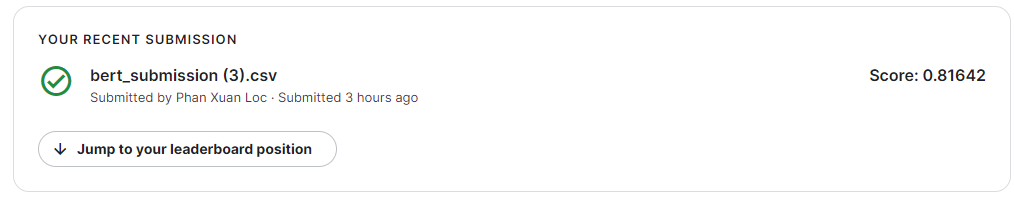


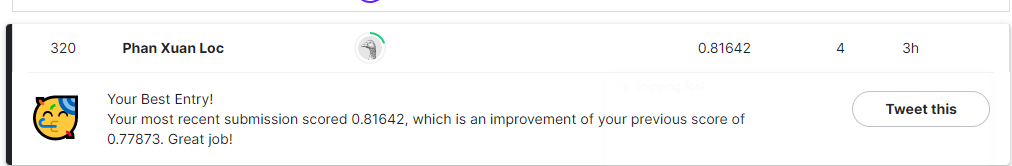